In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation # To visualize in animation
from IPython import display # To display in html
from matplotlib import rc
rc('text', usetex=True)

C:\Users\admin\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import os
curent = os.getcwd()
print(curent)

C:\Users\admin\Lab_training\Week9_10


# Softmax Regression
<hr>
Softmax function: $\text{softmax(z)} = \frac{\exp{z_i}}{\sum_{i} \exp{z_i}}$<br>
Loss function: For each points: $J(\textbf{W};\textbf{x}_i,y_i) = -\sum_{j=1}^{C}y_{ij} \log(a_{ij})$<br>
Gradient descent: SGD $\textbf{W} \leftarrow \textbf{W} - \eta.\textbf{x}_i.\textbf{e}_i^{T}$,   $\textbf{e}_i = \textbf{a}_i - \textbf{y}_i$<br>
Mini-batch $\textbf{W} \leftarrow \textbf{W} - \frac{\eta}{N_b} \textbf{X}_b^{T} \textbf{E}_b$, $\textbf{E} = \textbf{A} - \textbf{Y}$

**Weigh decay**

In [3]:
def softmax(z):
    return torch.exp(z)/torch.exp(z).sum(keepdims = True, dim = 1)

def softmax_stable(z):
    return softmax(z-torch.max(z, keepdims = True, dim = 1)[0])

In [4]:
def loss(X, Y, W, lam = 0.001):
    N = X.shape[0]
    A = softmax_stable(X.mm(W))
    return -1/N*(torch.sum(Y*torch.log(A)) + 0.5*lam*torch.linalg.norm(W,'fro')**2)

In [5]:
def softmax_grad(X, Y, W):
    N = X.shape[0]
    E = softmax_stable(X.mm(W)) - Y
    return 1./N*X.T.mm(E)

In [6]:
def softmax_fit(X, Y, W_init, eta = 0.01, lam = 0.001, nepoches = 2000, tol = 1e-5, batch_size = 10):
    W = [W_init]
    loss_hist = [loss(X, Y, W_init)]
    N, d = X.shape
    it = 0
    for epoch in range(nepoches):
        # shuffle data
        rd_ids = torch.randperm(N)
        for i in range(0, N, batch_size):
            indices = rd_ids[i:min(i+batch_size,N)]
            Xi = X[indices]
            Yi = Y[indices]
            g = softmax_grad(Xi, Yi, W[-1]) + lam*W[-1]
            W_new = W[-1] - eta*g
            if torch.linalg.norm(g)/(W_init.shape[0]*W_init.shape[1])<tol:
                return W, epoch, it, loss_hist
            W.append(W_new)
            loss_hist.append(loss(X,Y,W_new,lam))
            it+=1
    return W, epoch, it, loss_hist

In [7]:
def predict(X,W):
    A = softmax_stable(X.mm(W))
    return torch.argmax(A, dim = 1)

In [8]:
C, N = 5, 500 # number of classes and number of points per class
means = [[2, 2], [8, 3], [3, 6], [14, 2], [12, 8]]
cov = [[1, 0], [0, 1]]
np.random.seed(2)
X0 = torch.Tensor(np.random.multivariate_normal(means[0], cov, N))
X1 = torch.Tensor(np.random.multivariate_normal(means[1], cov, N))
X2 = torch.Tensor(np.random.multivariate_normal(means[2], cov, N))
X3 = torch.Tensor(np.random.multivariate_normal(means[3], cov, N))
X4 = torch.Tensor(np.random.multivariate_normal(means[4], cov, N))
X = torch.cat((X0, X1, X2, X3, X4), dim = 0) # each row is a datapoint
Xbar = torch.cat((X, torch.ones((X.shape[0], 1))), dim = 1) # bias trick
y = torch.asarray([0]*N + [1]*N + [2]*N+ [3]*N + [4]*N).reshape(-1,1) # label
Y = F.one_hot(y, num_classes = 5).squeeze() # onehot

In [9]:
W_init = torch.randn(Xbar.shape[1], C)
W, ep, it, loss_hist = softmax_fit(Xbar, Y, W_init, eta = 0.05, lam = 0.0001, tol = 1e-3, nepoches = 500)

In [10]:
print('Solution of Softmax Regression:\n', W[-1])
print('After {} epochs, {} iterations'.format(ep, it))
print('Final loss:', loss_hist[-1])

Solution of Softmax Regression:
 tensor([[-1.3439,  0.3614, -1.4344,  1.5957,  0.2735],
        [-0.6828, -0.7469,  2.4860, -2.1086,  1.4969],
        [11.0608,  3.3759, -1.4903, -6.6475, -7.4863]])
After 80 epochs, 20195 iterations
Final loss: tensor(0.0828)


C:\Users\admin\miniconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


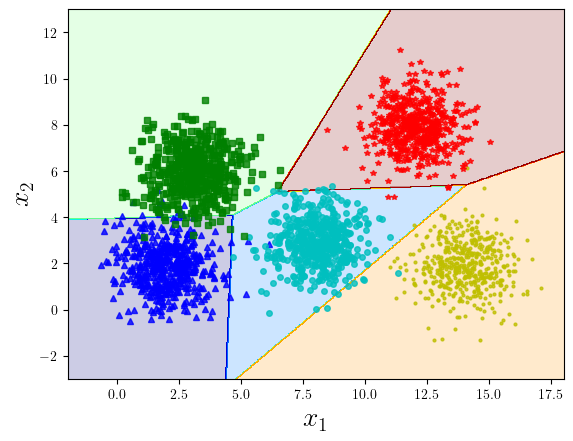

In [11]:
plt.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
plt.plot(X1[:, 0], X1[:, 1], 'co', markersize = 4, alpha = .8)
plt.plot(X2[:, 0], X2[:, 1], 'gs', markersize = 4, alpha = .8)
plt.plot(X3[:, 0], X3[:, 1], 'y.', markersize = 4, alpha = .8)
plt.plot(X4[:, 0], X4[:, 1], 'r*', markersize = 4, alpha = .8)
xx = torch.linspace(-2,18,500)
yy = torch.linspace(-3,13,500)
XX, YY = torch.meshgrid(xx, yy)
xx1 = XX.flatten().reshape(-1,1)
yy1 = YY.flatten().reshape(-1,1)

XX1 = torch.cat((xx1, yy1, torch.ones_like(xx1)), dim = 1)

Z = predict(XX1, W[-1])
plt.contourf(XX,YY,Z.reshape(XX.shape), 200, cmap = 'jet', alpha = 0.2)

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.savefig(curent+'\ForLatex\softmax_2.pdf', bbox_inches = 'tight')

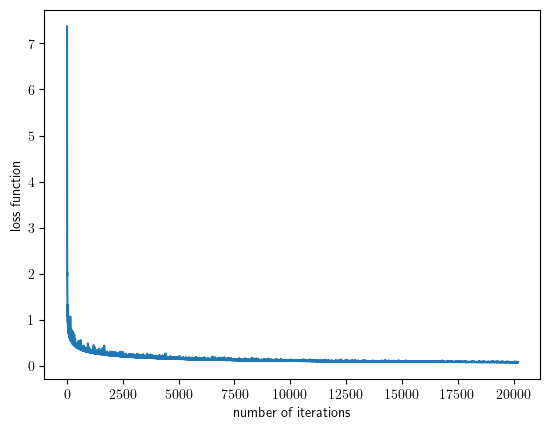

In [12]:
# Hist
plt.plot(loss_hist)
plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.savefig(curent+'\ForLatex\softmax_loss.pdf');

In [13]:
y_hat = predict(Xbar, W[-1])
accuracy = Accuracy(task = 'multiclass', num_classes = 5)
print('Training Accuracy score:', accuracy(y.flatten(), y_hat))

Training Accuracy score: tensor(0.9788)
